# Seattle Pet Licenses Data Extraction and Analysis

The city of Seattle makes available its database of pet licenses issued from 2005 to the beginning of 2017 as part of the city's ongoing [Open Data Initiative](https://data.seattle.gov/). This notebook will explore extracting the data from Seattle's Open Data portal using [requests](http://docs.python-requests.org/en/master/), then transform the extracted JSON data into a workable dataset with [pandas](https://pandas.pydata.org/) to analyze and investigate the pet license database. 

## About Seattle Pet Licensing

The [city of Seattle requires pets over eight weeks old be licensed](https://library.municode.com/wa/seattle/codes/municipal_code?nodeId=TIT9AN_CH9.25ANCO_9.25.050ANLIPEGE). There are several benefits to [licensing one's pet](https://www.seattle.gov/animal-shelter/license), including a return ride home if your pet is lost, and easier contact from a veterinarian if your pet is unfortunately injured. If the licensing is performed at the Seattle Animal Shelter on the third Saturday of any given month, a free rabies vaccine is included, as well as other vaccines and a microchip for a small additional fee.

## Getting Started

Import the [`%matplotlib inline`](http://ipython.readthedocs.io/en/stable/interactive/plotting.html) magic function for displaying the output visualizations inline in the notebook and import the libraries that will be used in this section of the analysis.

In [1]:
%matplotlib inline

import requests
import pandas as pd
import numpy as np
from urllib.error import HTTPError
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.simplefilter('ignore')

/Users/aaron/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Here, we set the formatting for the plots created with [seaborn](https://seaborn.pydata.org/index.html) that appear later in the analysis.

In [2]:
sns.set(font_scale=2, palette=sns.color_palette("Set2", 10))
sns.set_style("ticks")

## Getting the Data

We extract the data programmatically from the Seattle Open Data Portal. The portal utilizes [Socrata](https://socrata.com/) to host its data. Therefore we will be working with the Socrata API. The Seattle pet licenses database API endpoint can be found on the [dataset's information page](https://data.seattle.gov/Community/Seattle-Pet-Licenses/jguv-t9rb) by clicking the API button in the top-right corner. 

Socrata's [paging documentation](https://dev.socrata.com/docs/paging.html) states there is a return limit of 1,000 for each call. Therefore, we need to page the results to capture the entire dataset. The default format returned from the API is JSON, though other formats such as CSV and XML are also available. We select the default JSON format and collect the results into a list that we can later use to build a pandas DataFrame. The following block extracts the data from the API into a list until there are no more results to return. 

In [3]:
count = 1000
offset = 0
params = {'$limit': count, '$offset': offset}
endpoint = 'https://data.seattle.gov/resource/87w5-fd6d.json'

results = []

while True:

    try:
        r = requests.get(endpoint, params=params)
        rcontent = r.json()
        
        if rcontent == []:
            break

        results.append(rcontent)
        offset += count
        params['$offset'] = offset

    except HTTPError as err:

        if err.response.status_code == '404':
            break
        else:
            print(err.response.status_code)

The data is now stored in a list that we can iterate through and normalize each JSON result using pandas's handy [json_normalize](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.io.json.json_normalize.html) function. Once all the JSON data is collected into a DataFrame, we can inspect the number of rows and print the first few rows of the data. 

In [4]:
petlicenses = pd.DataFrame()

for i in results:
    petlicenses = petlicenses.append(pd.io.json.json_normalize(i))

print(len(petlicenses))
petlicenses.head()

66042


,animal_s_name,license_issue_date,license_number,primary_breed,secondary_breed,species,zip_code
0,Ozzy,2005-03-29T00:00:00.000,130651,"Dachshund, Standard Smooth Haired",NaN,Dog,98104
1,Jack,2009-12-23T00:00:00.000,898148,"Schnauzer, Miniature","Terrier, Rat",Dog,98107
2,Ginger,2006-01-20T00:00:00.000,29654,"Retriever, Golden","Retriever, Labrador",Dog,98117
3,Pepper,2006-02-07T00:00:00.000,75432,Manx,Mix,Cat,98103
4,Addy,2006-08-04T00:00:00.000,729899,"Retriever, Golden",NaN,Dog,98105


The row count is just over 66k, which is the same number of rows given on the [dataset's portal page](https://data.seattle.gov/Community/Seattle-Pet-Licenses/jguv-t9rb). We see the data has seven columns, and are the same as listed on the data's webpage. We now have a nice, tidy dataset that was created programmatically with a combination of libraries! Isn't that much more satisfying than just downloading the data as a .csv from the website? (Of course, it is).

It is often a good idea to save the extracted and transformed data onto the disk to avoid having to repeatedly get the data from the API if it is to be used later. We quickly save the DataFrame as a .csv using the [`to_csv`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_csv.html) method.

In [5]:
petlicenses.to_csv('../../data/seattle pet licenses/seattle_pet_licenses.csv', index=False, encoding='utf-8')

## Exploratory Data Analysis of the Seattle Pet Licenses Dataset

Now that we have a tidy dataset to work with, we can move onto exploring the data! As a start, let's see how many pet licenses have been issued by species of pet.

In [6]:
petlicenses['species'].value_counts()

Dog          43076
Cat          22915
Livestock       51
Name: species, dtype: int64

We see a vast disparity, almost 2 to 1, between the count of licenses issued to dogs and cats. 'Livestock,' according to the [pet licensing municipal code](https://library.municode.com/wa/seattle/codes/municipal_code?nodeId=TIT9AN_CH9.25ANCO_9.25.050ANLIPEGE), include miniature goats and potbellied pigs. Therefore, we wouldn't expect to see too many licenses issued to livestock in comparison to dogs or cats, but considering the dataset encompasses all of Seattle's issued pet licenses over a 12 year period, 51 seems rather low.

According to a [survey conducted by the American Pet Products Association conducted between 2017 and 2018](https://www.animalsheltering.org/page/pets-by-the-numbers), there were an estimated 94.2 million cats, averaging two cats per household and an estimated 89.7 million dogs averaging just under 1.5 dogs per household. Assuming these numbers are proportional to the pet ownership population in Seattle, why are dogs licensed almost twice as much as cats? Some possible factors include:

* One of the main benefits of getting a license for one's pet is the pet can be returned at no cost should the pet, unfortunately, go missing. As dogs are often outdoors much more frequently than cats for walks and such, perhaps the thought of one's dog becoming lost is more prevalent in dog owners' minds. 
* According to another [survey conducted in 2012 by the American Veterinary Medical Association](https://www.animalsheltering.org/page/pets-by-the-numbers), 66.7% of dog owners surveyed thought their dog(s) are a part of their family, compared to 56.1% of cat owners surveyed. The perception of family inclusiveness could be another factor for the difference in licensing rates as it can be reasonably assumed that owners who consider their pets part of their family would be more likely to purchase a license.
  - The same AVMA survey also found that the average amount spent on veterinary care for each dog per year was \$227 compared to just \$90 for cats. Although this could be further evidence of the general attitude towards dogs and cats as family members, it is typically more difficult to determine if a cat is ill as they are not prone to showing they are not well, therefore this could also play a role in the difference in amount spent on care.
  
As we are more interested in dog and cat pet licenses for this analysis and the low overall volume of licenses issued to livestock-classified pets, we remove the livestock licenses from the data.

In [7]:
petlicenses = petlicenses.loc[petlicenses['species'] != 'Livestock']

### Finding Most Common Dog and Cat Names

The pet's name for each license is also available in the licenses dataset. Using this information, can we find any similarity in the names of cats and dogs given by their owners? To answer this question, let's first plot the top ten cat and dog names by total count.

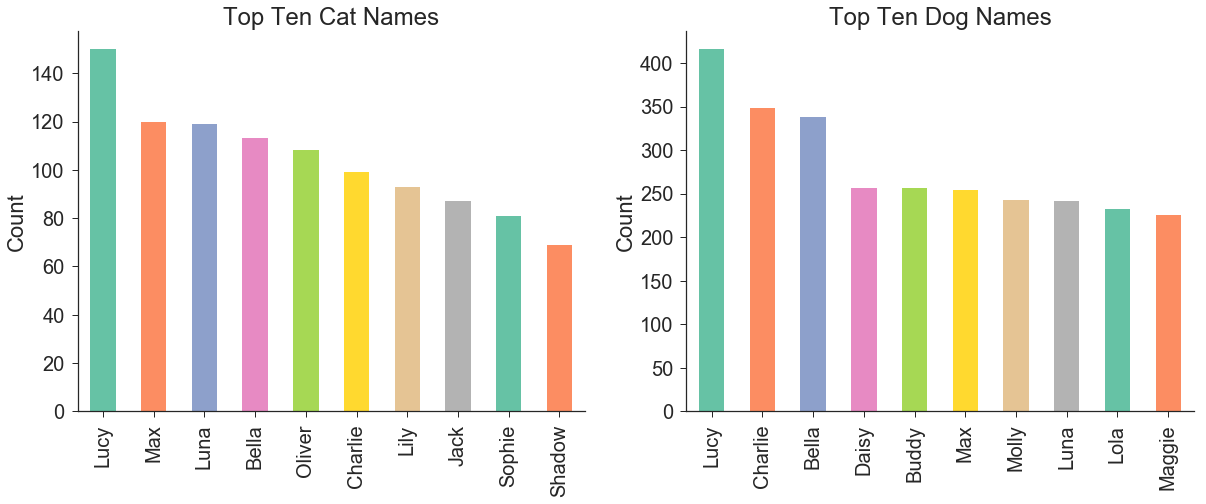

In [8]:
f, ax = plt.subplots(1, 2, figsize=(20, 7))

c = petlicenses[petlicenses['species'] == 'Cat']['animal_s_name'].value_counts()[0:10].plot(kind='bar', 
                                                                                            ax=ax[0], 
                                                                                            title='Top Ten Cat Names')
d = petlicenses[petlicenses['species'] == 'Dog']['animal_s_name'].value_counts()[0:10].plot(kind='bar', 
                                                                                            ax=ax[1], 
                                                                                            title='Top Ten Dog Names')
c.set_ylabel('Count')
d.set_ylabel('Count')

sns.despine()

The most common name for both dogs and cats is Lucy, with the names Max, Luna, Bella, Charlie, and Max also reaching the top 10 names for both animals. Given that 60% of the top ten cat and dog names are the same between animals, we can reasonably assume there is a decent amount of commonality in names amongst dogs and cats.

Now let's examine the 50 most common cat and dog names by total count and see the intersection of names using some of Python's available [set operations](https://docs.python.org/2/library/sets.html). We print the names that are shared by cats and dogs in the top 50 names, as well as the total number.

In [9]:
cat_names = petlicenses[petlicenses['species'] == 'Cat']['animal_s_name'].value_counts()[0:50].index.tolist()
dog_names = petlicenses[petlicenses['species'] == 'Dog']['animal_s_name'].value_counts()[0:50].index.tolist()

common_names = set(cat_names).intersection(dog_names)
print(len(common_names), common_names)

30 {'Penny', 'Zoe', 'Milo', 'Lucy', 'Buddy', 'Oscar', 'Chloe', 'Sadie', 'Ruby', 'Bella', 'Oliver', 'Olive', 'Lily', 'Sophie', 'Sam', 'Maggie', 'Stella', 'Henry', 'Lulu', 'Lola', 'Charlie', 'Toby', 'Molly', 'Gracie', 'Luna', 'Ginger', 'Daisy', 'Pepper', 'Jack', 'Max'}


Interestingly, 30 of the 50 top cat and dog names are shared, the same ratio (60%) found in the list of top ten names. 

### Determining the Most Common Pet Breeds

According to the [American Kennel Club](http://www.akc.org/content/news/articles/most-popular-dog-breeds-full-ranking-list/), Labrador Retrievers, German Sheperds, and Golden Retrievers are the most popular dog breeds of 2016 and have been since 2013. The top three most popular cat breeds according to a recent article by [The Spruce](https://www.thespruce.com/personalities-of-popular-cat-breeds-554219) are the Siamese, Persian, and Maine Coon. Using the primary breed information available in the pet license database, we can see if dog and cat owners in Seattle confirm the results as reported by the articles.

Here, we plot the top 20 most frequently appearing primary breeds of dogs and cats. 

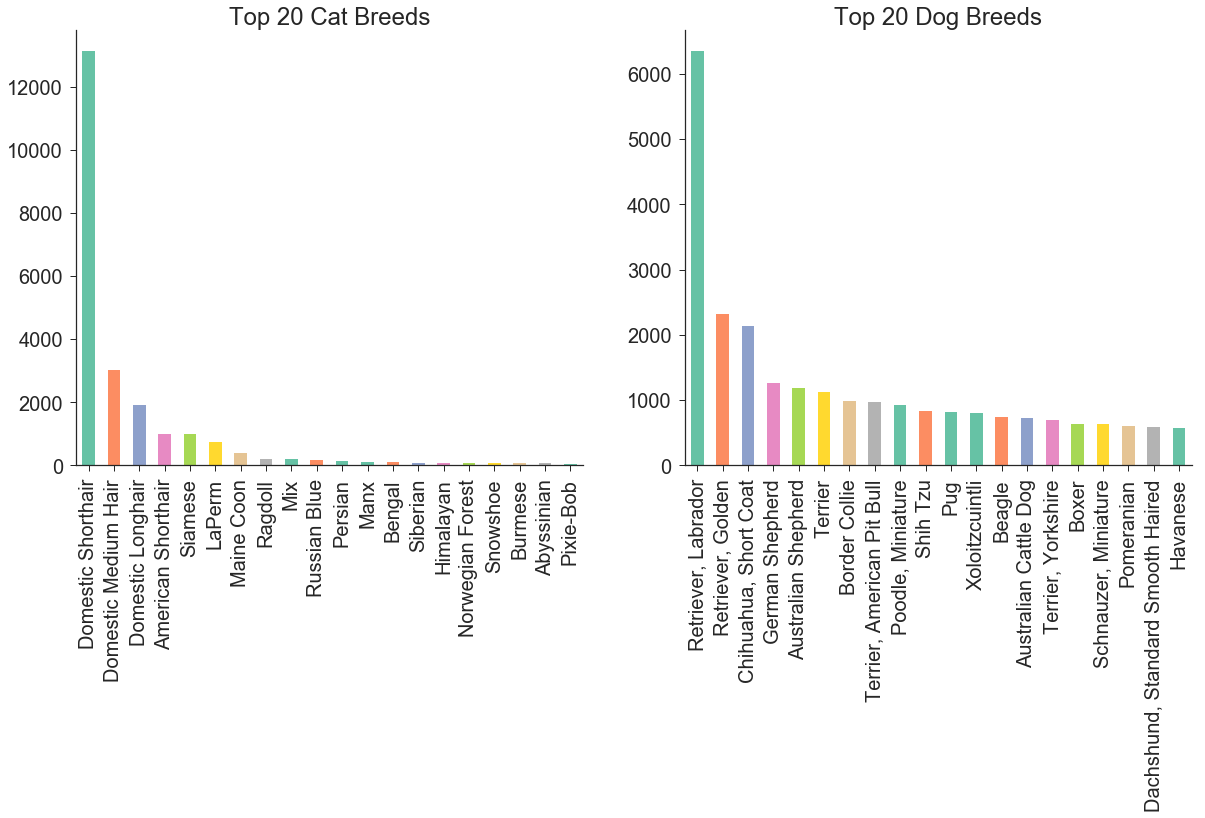

In [10]:
f, ax = plt.subplots(1, 2, figsize=(20, 8))

petlicenses[petlicenses['species'] == 'Cat']['primary_breed'].value_counts()[0:20].plot(kind='bar', 
                                                                                        ax=ax[0], 
                                                                                        title='Top 20 Cat Breeds')
petlicenses[petlicenses['species'] == 'Dog']['primary_breed'].value_counts()[0:20].plot(kind='bar', 
                                                                                        ax=ax[1], 
                                                                                       title='Top 20 Dog Breeds')

sns.despine()

Based on the available data, we see the top three dog breeds are Labrador and Golden Retrievers and Short Coat Chihuahuas, with German and Australian Shepherds making up the fourth and fifth most popular breeds. The Australian Shepherd and Chihuahua are the 16th and 30th most popular breed on the AKC's list, respectively. Therefore, the results reported by the American Kennel Club are similar to most frequently appearing breeds in the data available, with a few deviations.

Technically speaking, domestic cats are not considered a pure breed, as they are the mix of several different breeds. Excluding the domestic breeds, we see the next most popular cat breeds are the American Shorthair, Siamese, and the LaPerm. The American Shorthair is the twelveth most popular breed in The Spruce's list while the LaPerm doesn't make an appearance.

Dog breeds also have a more even distribution while cat breeds are heavily skewed towards the domestic breeds, particularly the short hair variety. There are many potential reasons for this, of which the primary one is cat breeding is relatively new in comparison to breeding dogs for specific traits. Thus there are far fewer cat breeds recognized by the relevant governing bodies than dogs. It is also much more difficult to identify the breed of a cat, the only surefire way being genetic testing.

### Analysis of Pet Licensing by Geography

The [zip code](https://en.wikipedia.org/wiki/ZIP_Code) of the pet's home is also given in the dataset. As the data is user-generated, we need to perform a few cleaning steps to get the zip codes all in a similar format before we can analyze the data further.

Zip codes are often given a four-digit suffix beginning with a hyphen for more specificity regarding the particular area. This suffix is not required for our purposes. Therefore we convert the zip code into a string and split the data by the hype and keep only the first piece.

In [11]:
petlicenses['zip_code'] = petlicenses['zip_code'].astype(str)
petlicenses['zip_code'] = petlicenses['zip_code'].str.split('-').str[0]

Now that we have a cleaner set of zip codes, we can start by plotting which zips have the most licensed pets. As there are quite a lot of zip codes, we focus on the top 15 by volume. A `count` column filled with $1$s is also added for convenience when plotting.

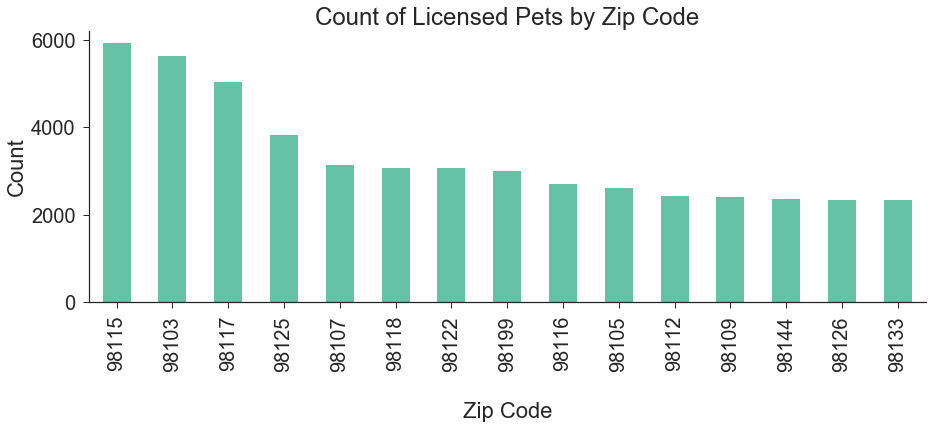

In [12]:
petlicenses['count'] = 1

petlicenses_zip = pd.pivot_table(petlicenses, 
                                     index=['zip_code'], 
                                     values=['count'], aggfunc=np.sum)

top15_zips = petlicenses_zip.sort_values('count', ascending=False)[0:15]

z = top15_zips.plot(kind='bar', figsize=(15, 5), legend=False, title='Count of Licensed Pets by Zip Code')

z.set_ylabel('Count')
z.set_xlabel('Zip Code')
z.xaxis.labelpad = 30
sns.despine()

Only three zip codes, [98115](https://www.google.com/maps/place/Seattle,+WA+98115/data=!4m2!3m1!1s0x5490138e69f1749b:0xeeed558decac03c2?sa=X&ved=0ahUKEwiJ8qPQounZAhWnqFQKHWNnB88Q8gEINzAB), [98103](https://www.google.com/maps/place/Seattle,+WA+98103/data=!4m2!3m1!1s0x54901401e2823f15:0x177b6b4bc116a697?sa=X&ved=0ahUKEwjgt4vcounZAhXmwFQKHfSFABEQ8gEIODAB), and [98117](https://www.google.com/maps/place/Seattle,+WA+98117/data=!4m2!3m1!1s0x54901681a6d360c9:0xf4e6b3535e6271da?sa=X&ved=0ahUKEwjjs9LpounZAhXCyFQKHZ8YB3MQ8gEINzAB) have more then 5,000 licensed pets. Anecdotally, the fact that the 98115 zip code has the most licensed pets doesn't suprise as I lived in the 98115 zip code for a number of years and could always see a number of dogs being walked throughout the day.

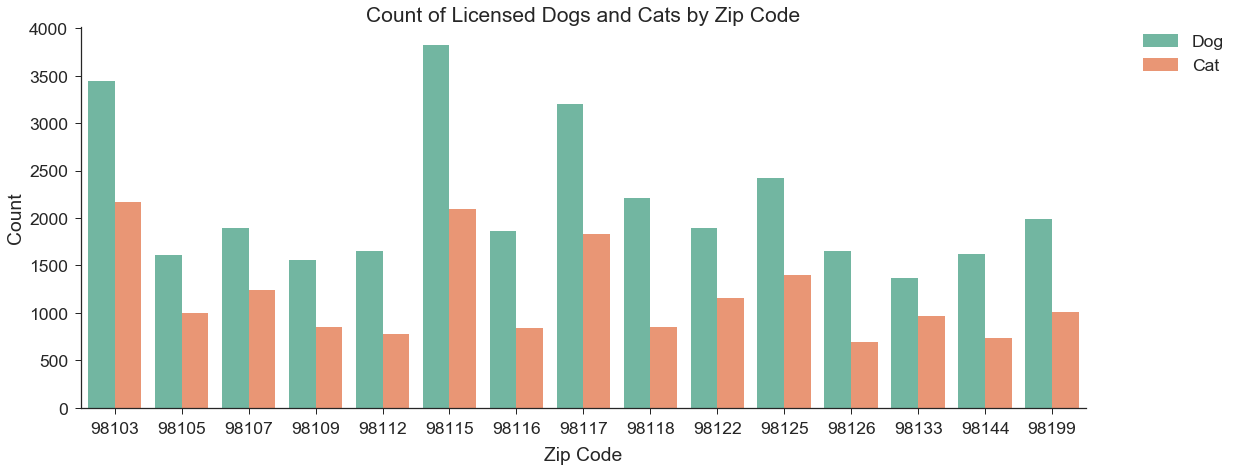

In [13]:
petlicenses_species_zip = pd.pivot_table(petlicenses, 
                                     index=['zip_code', 'species'], 
                                     values=['count'], aggfunc=np.sum).sort_values(by='count', ascending=False).reset_index()

petlicenses_species_zip = petlicenses_species_zip.loc[petlicenses_species_zip['zip_code'].isin(top15_zips.index)]

plt.figure(figsize=(18, 7))

sns.set(font_scale=1.75, palette=sns.color_palette("Set2", 10))
sns.set_style("ticks")

bar = sns.barplot(x='zip_code', y='count', hue='species', data=petlicenses_species_zip)
bar.set_title('Count of Licensed Dogs and Cats by Zip Code')
bar.set_ylabel('Count')
bar.set_xlabel('Zip Code')

bar.xaxis.labelpad = 10
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

As one would reasonably expect given the knowledge of an almost 2:1 ratio in the number of cats licensed compared to dogs, the top 15 zip codes by total licensed pets also shown a significant difference in licensed dogs and cats. However, some of these differences are not as stark, for example, the zip codes [98133](https://www.google.com/maps/place/Seattle,+WA+98133/@47.7388175,-122.4199728,12z/data=!3m1!4b1!4m5!3m4!1s0x5490112054ed461b:0x200c29ea0f6db746!8m2!3d47.7393027!4d-122.3435335) and [98105](https://www.google.com/maps/place/Seattle,+WA+98105/@47.6653979,-122.3129935,13z/data=!3m1!4b1!4m5!3m4!1s0x54901483afc82e4f:0x6849e41d46bef642!8m2!3d47.6614244!4d-122.2683743) show a fair number of cats licensed compared to dogs.

### Finding Popular Dog and Cat Breeds by Zip Code

Earlier in the analysis, we found the most frequently appearing cat and dog breeds in the pet licenses database. Does the frequency of breeds appearing differ when viewed at a zip code level? That is, are there areas of Seattle that favor a particular dog or cat breed over others? One could reasonably hypothesize that smaller dogs such as Chihuahuas, Miniature Poodles, and Pugs would be more common in the denser areas of the city due to space and that some apartment buildings charge extra for larger breeds of dogs.

The following creates two new data frames that contain the top five cat and dog breeds for the top five zip codes. A rank column is added to find the most frequently occurring breeds by each zip code using pandas's [`groupby`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) and [`rank()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rank.html) methods that are then used to filter the breeds by the top five.

In [14]:
breeds_zipcode = pd.pivot_table(petlicenses, 
                               index=['primary_breed', 'zip_code', 'species'], 
                               values=['count'], aggfunc=np.sum).reset_index().sort_values('count', ascending=False)

cats = breeds_zipcode.loc[breeds_zipcode['species'] == 'Cat']
dogs = breeds_zipcode.loc[breeds_zipcode['species'] == 'Dog']

top5_zips = top15_zips[0:5]

cats['rank'] = cats.groupby('zip_code')['count'].rank(method='dense', ascending=False)

cats = cats.loc[cats['zip_code'].isin(top5_zips.index)]

cats_top5 = cats.loc[cats['rank'] <= 5.0]

cats_top5 = pd.pivot_table(cats_top5, 
                           index=['zip_code', 'primary_breed'], 
                           values=['count'], 
                           aggfunc=np.sum).reset_index().sort_values(by='count', ascending=False)

dogs['rank'] = dogs.groupby('zip_code')['count'].rank(method='dense', ascending=False)
dogs = dogs.loc[dogs['zip_code'].isin(top5_zips.index)]

dogs_top5 = dogs.loc[dogs['rank'] <= 5.0]

dogs_top5 = pd.pivot_table(dogs_top5, 
                           index=['zip_code', 'primary_breed'], 
                           values=['count'], 
                           aggfunc=np.sum).reset_index().sort_values(by='count', ascending=False)

Plot the top five most frequently occurring dog and cat breeds within the zip codes with the most licensed pets.

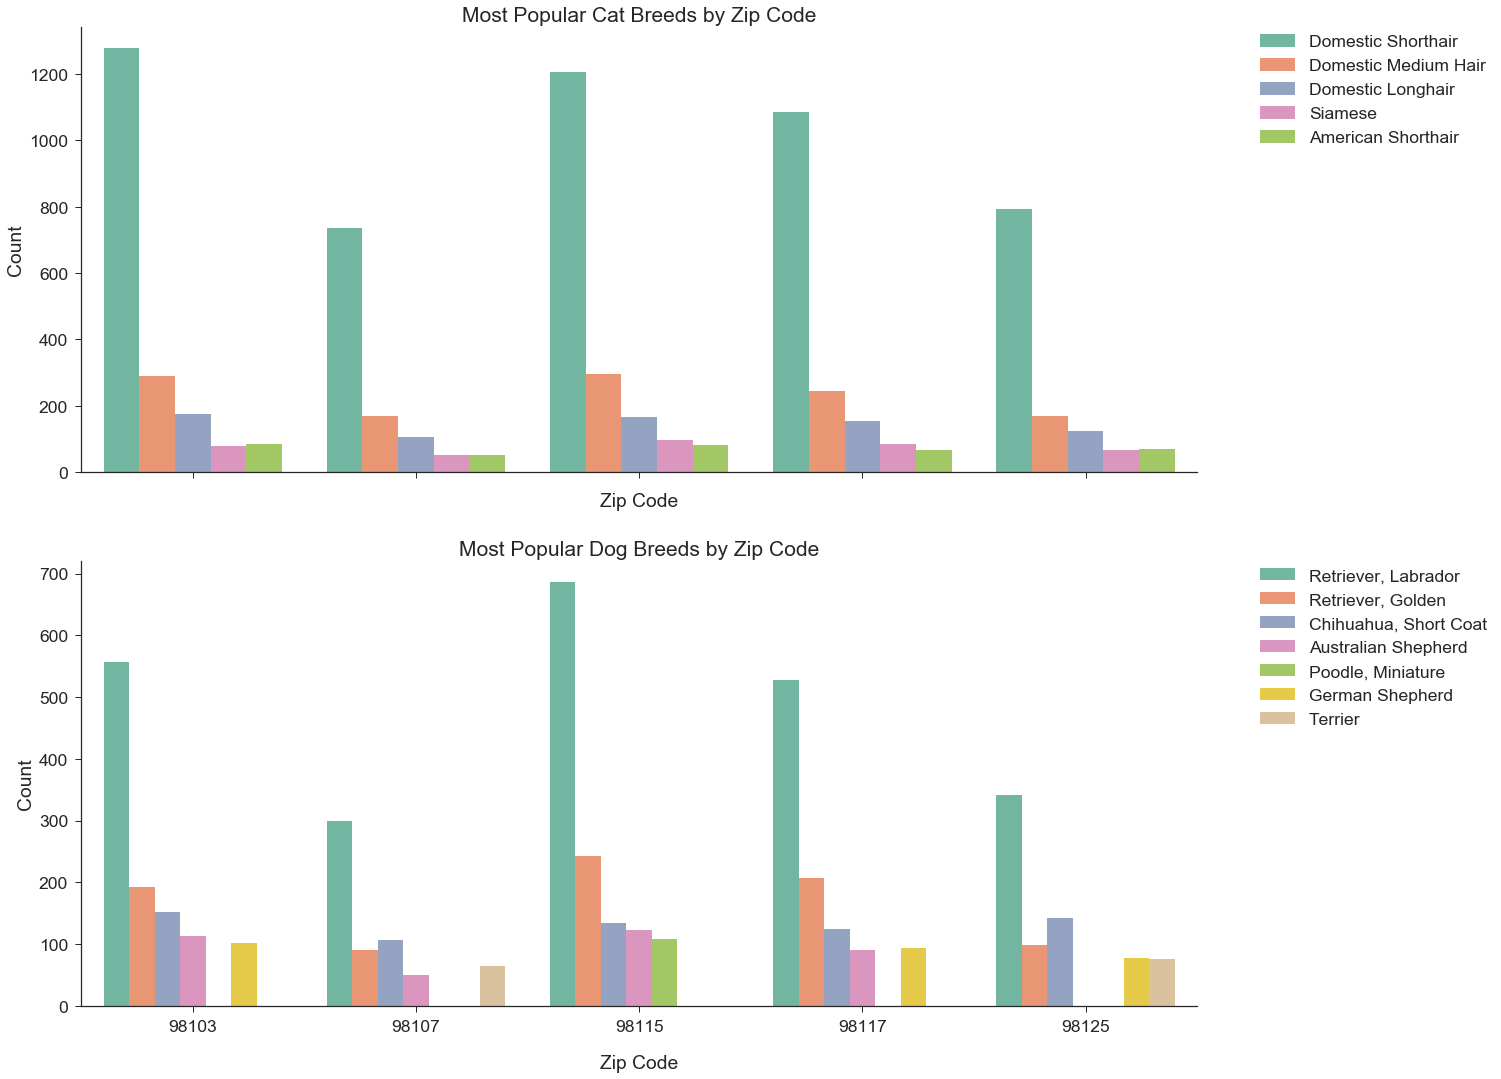

In [15]:
f, ax = plt.subplots(2, 1, figsize=(20, 18), sharex=True)

cat_bar = sns.barplot(x='zip_code', y='count', hue='primary_breed', data=cats_top5, ax=ax[0])
dog_bar = sns.barplot(x='zip_code', y='count', hue='primary_breed', data=dogs_top5, ax=ax[1])

cat_bar.set_title('Most Popular Cat Breeds by Zip Code')
cat_bar.set_ylabel('Count')
cat_bar.set_xlabel('Zip Code')

dog_bar.set_title('Most Popular Dog Breeds by Zip Code')
dog_bar.set_ylabel('Count')
dog_bar.set_xlabel('Zip Code')

cat_bar.xaxis.labelpad = 20
dog_bar.xaxis.labelpad = 20

sns.despine()

cat_bar.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
dog_bar.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

As one might reasonably suspect, the most common breeds overall are also the most frequently appearing within each zip code, although there are several ties for the fifth most popular dog breed. Is there any more variety when the domestic cat breeds and retriever dog breeds are removed from the results before ranking?

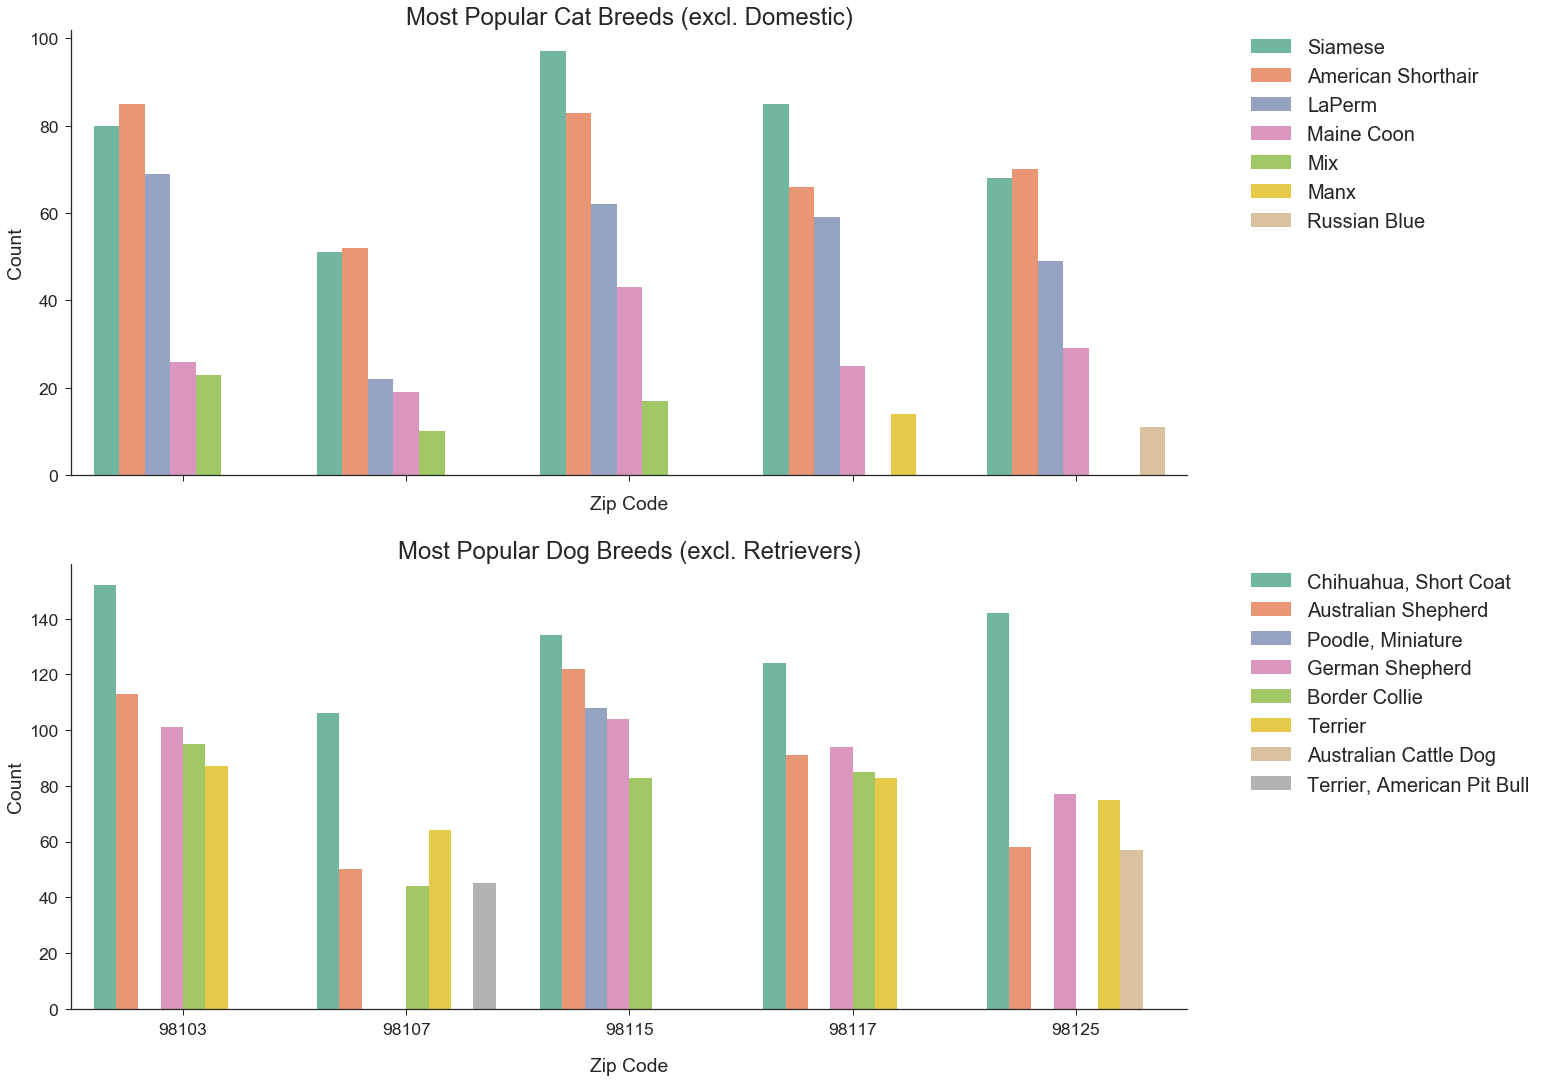

In [16]:
cats_non_domestic = cats.loc[cats['primary_breed'].str.contains('Domestic') == False]

cats_non_domestic['rank'] = cats_non_domestic.groupby('zip_code')['count'].rank(method='dense', ascending=False)

cats_non_domestic_top5 = cats_non_domestic.loc[cats_non_domestic['rank'] <= 5.0]

cats_non_domestic_top5 = pd.pivot_table(cats_non_domestic_top5, 
                           index=['zip_code', 'primary_breed'], 
                           values=['count'], 
                           aggfunc=np.sum).reset_index().sort_values(by='count', ascending=False)

dogs_non_retriever = dogs.loc[dogs['primary_breed'].str.contains('Retriever') == False]

dogs_non_retriever['rank'] = dogs_non_retriever.groupby('zip_code')['count'].rank(method='dense', ascending=False)

dogs_non_retriever_top5 = dogs_non_retriever.loc[dogs_non_retriever['rank'] <= 5.0]

dogs_non_retriever_top5 = pd.pivot_table(dogs_non_retriever_top5, 
                           index=['zip_code', 'primary_breed'], 
                           values=['count'], 
                           aggfunc=np.sum).reset_index().sort_values(by='count', ascending=False)

f, ax = plt.subplots(2, 1, figsize=(20, 18), sharex=True)

sns.set(font_scale=2, palette=sns.color_palette("Set2", 10))
sns.set_style("ticks")

cat_bar = sns.barplot(x='zip_code', y='count', hue='primary_breed', data=cats_non_domestic_top5, ax=ax[0])
dog_bar = sns.barplot(x='zip_code', y='count', hue='primary_breed', data=dogs_non_retriever_top5, ax=ax[1])

cat_bar.set_title('Most Popular Cat Breeds (excl. Domestic)')
cat_bar.set_ylabel('Count')
cat_bar.set_xlabel('Zip Code')

dog_bar.set_title('Most Popular Dog Breeds (excl. Retrievers)')
dog_bar.set_ylabel('Count')
dog_bar.set_xlabel('Zip Code')

cat_bar.xaxis.labelpad = 20
dog_bar.xaxis.labelpad = 20

sns.despine()

cat_bar.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
dog_bar.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

After the removal of the domestic cat breeds, we see there is a relatively even distribution of several of the most popular breeds including the Siamese, American Shorthair, LaPerm, and the Maine Coon. There also appears to be several Manx and Russian Blues in the 98117 and 98125 zip codes, which is unique from the other zip codes with the most licensed pets. The frequency of breeds is also somewhat consistent across zip codes, with Siamese and American Shorthairs being the most popular followed by LaPerms and Maine Coons. Could these results be indicative of a general breed preference amongst Seattle cat owners? Given the comparatively low frequency of these breeds appearing in comparison to the domestic breeds, there likely isn't much of a relationship; however, it could be interesting to compare these results with a survey or some other data set that gave cat owner breed preferences.

Similar to the Siamese cat, Short Hair Chihuahuas are the most popular dog breeds after the exclusion of Labrador and golden retrievers. What is perhaps most interesting is Miniature Poodles are the third most popular breed in and only in the 98115 zip code. We also see American Pit Bull Terriers, and Australian Cattle Dogs are popular in the 98107 and 98125 zip codes, but not in the other zip codes. As seen in the top cat breeds, the top dog breeds across the considered zip codes are quite consistent, with Australian and German Shepherds, Border Collies and Terriers following Short Hair Chihuahuas in general.

### Time Series Analysis of Issued Pet Licenses

The Seattle pet licenses dataset contains the date the license was registered with the city, which gives us the ability to investigate how the volume of licenses being issued has changed over time. To begin analyzing the time series, we first convert the datasets `issue_date` column into a datetime format using pandas's [`to_datetime`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) function.

In [17]:
petlicenses['issue_date'] = pd.to_datetime(petlicenses['license_issue_date'])

Plot the number of licenses issued by day for all the days included in the dataset.

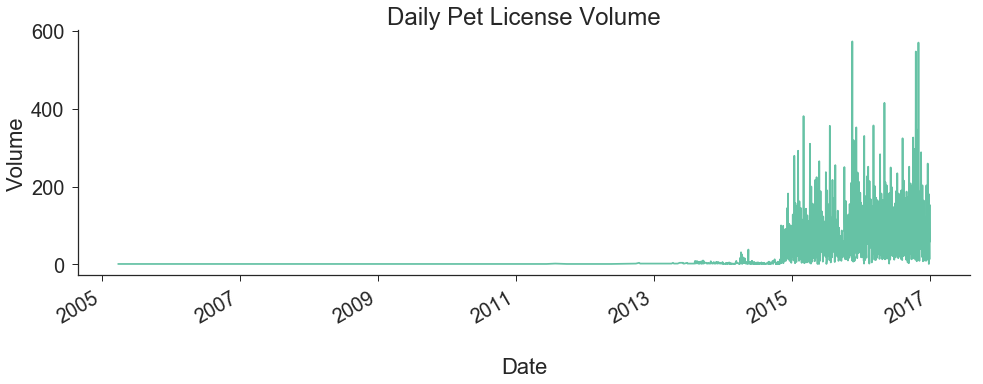

In [18]:
petlicense_date = pd.pivot_table(petlicenses, index=['issue_date'], values=['count'], aggfunc=np.sum)
p = petlicense_date.plot(figsize=(16, 5), legend=False, title = 'Daily Pet License Volume')

p.set_ylabel('Volume')
p.set_xlabel('Date')
p.xaxis.labelpad = 30
sns.despine()

There appears to be very little to no pet licenses being issued from the beginning in 2005 up until about mid-2013 when some noticeable volume began to emerge. It isn't until near the end of 2014 that the number of issued pet licenses balloons to over a hundred or more each day. 

What could cause such an extreme shift in volume that has continued for just over three years after almost no activity for close to 10 years? Some cursory searching on Google News did not return anything definitive that could be a possible factor of the sudden change, nor did any further investigation on the Seattle Animal Shelter website.

To get a better visualization of how the data appears to trend, split the data by pre-2015 and post-2015 and plot.

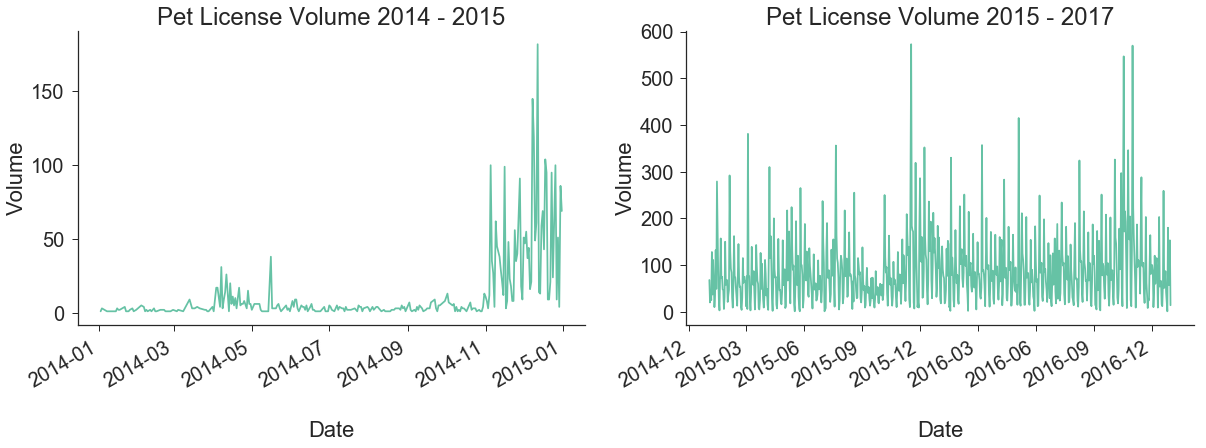

In [19]:
f, ax = plt.subplots(1, 2, figsize=(20, 6))

petlicense_date2015 = petlicense_date.loc[petlicense_date.index >='2015-01-01']
petlicense_date2014 = petlicense_date.loc[(petlicense_date.index < '2015-01-01') & (petlicense_date.index >= '2014-01-01')]

p1 = petlicense_date2014.plot(ax=ax[0], legend=False, title='Pet License Volume 2014 - 2015')
p2 = petlicense_date2015.plot(ax=ax[1], legend=False, title='Pet License Volume 2015 - 2017')

p1.set_ylabel('Volume')
p1.set_xlabel('Date')
p1.xaxis.labelpad = 30
sns.despine()

p2.set_ylabel('Volume')
p2.set_xlabel('Date')
p2.xaxis.labelpad = 30
sns.despine()

The data plotted separately further displays the stark difference in pet licensing volume that began in November of 2014 and has continued as far as the data is available. Post-2015, it seems there are a few peaks at the end of each year around November and December, but other than that there doesn't appear to be any significant trend.

We can explore the trend and other components of the time series by performing [time series decomposition](https://en.wikipedia.org/wiki/Decomposition_of_time_series). Decomposing a time-series into unique components that each represent a particular facet of the time series data helps identify any cyclical or seasonal trends and is an essential piece of any time series analysis.

The [statsmodels](http://www.statsmodels.org/stable/index.html) library provides a function [`seasonal_decompose`] that performs decomposition on a time series. The frequency parameter `freq` is set to 12 to indicate monthly frequency, though other values such as 7 (weekly frequency) or 3 (quarterly frequency), could also be used.

In [20]:
decomp2015 = sm.tsa.seasonal_decompose(petlicense_date2015, freq=12)

To get a more visually appealing graph of the decomposed time-series, we access the attributes that represent the fitted components and plot using pandas's convenient [visualization methods](https://pandas.pydata.org/pandas-docs/stable/visualization.html).

Text(0.5,0,'Date')

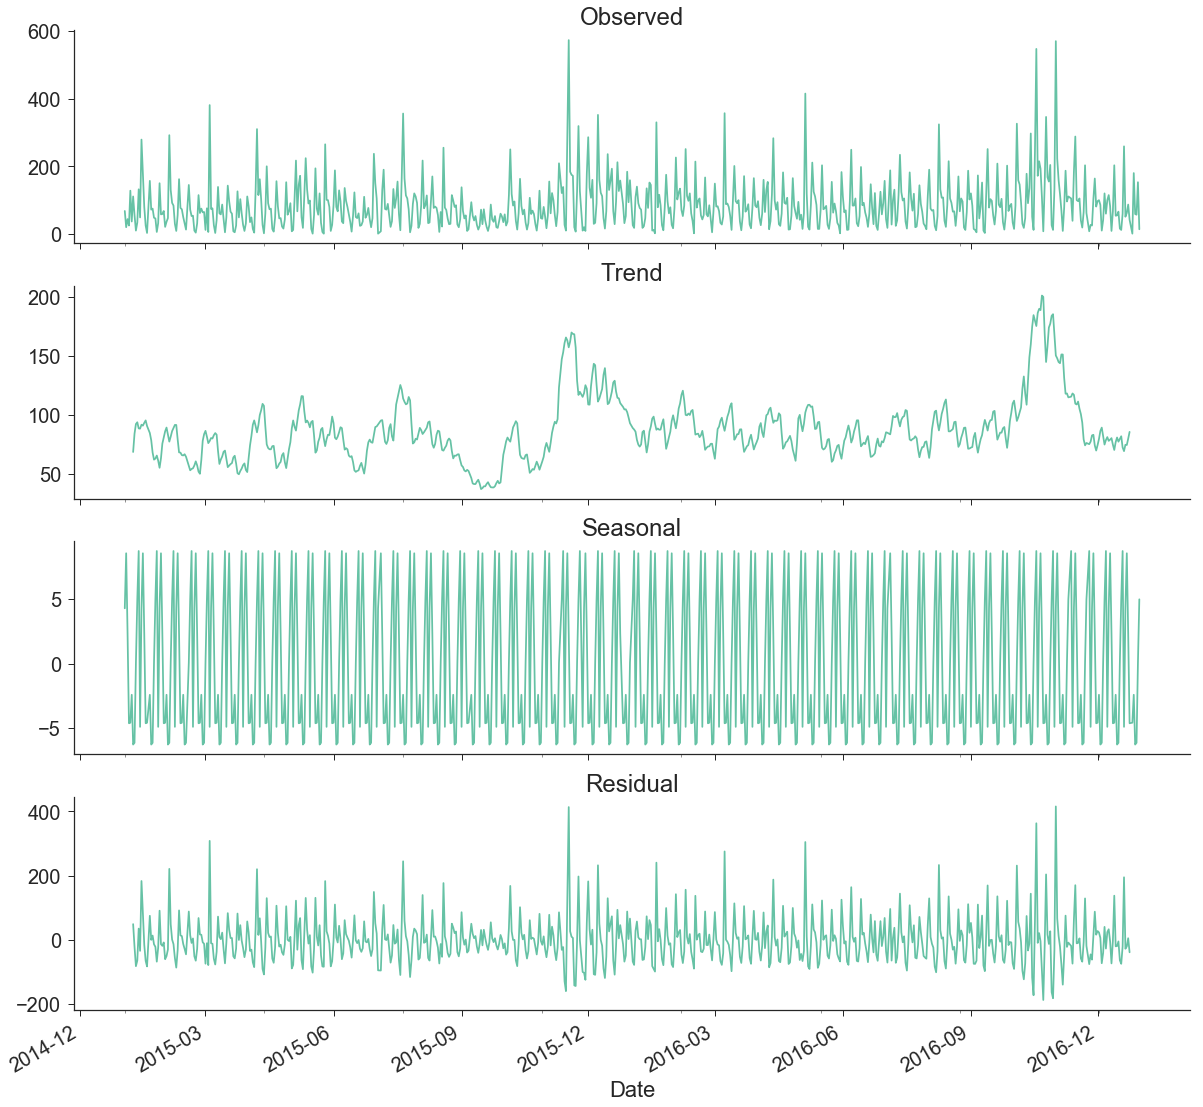

In [21]:
f, ax = plt.subplots(4, 1, figsize=(20, 20), sharex=True, squeeze=True)

decomp2015.observed.plot(ax=ax[0], title='Observed', legend=False)
decomp2015.trend.plot(ax=ax[1], title='Trend', legend=False)
decomp2015.seasonal.plot(ax=ax[2], title='Seasonal', legend=False)
g = decomp2015.resid.plot(ax=ax[3], title='Residual', legend=False)

sns.despine()
g.set_xlabel('Date')

There does appear to be a trend judging by the component resulting from the decomposition, with some ups and downs throughout the year and then rising significantly near the end of the year. The seasonal component is minimal, thus there likely isn't much, if any, seasonality. To get a better sense of the trend, we can overlay the component with the original time series.

Text(0.5,1,'Daily Volume of Pet Licenses with Trend Overlay (Orange)')

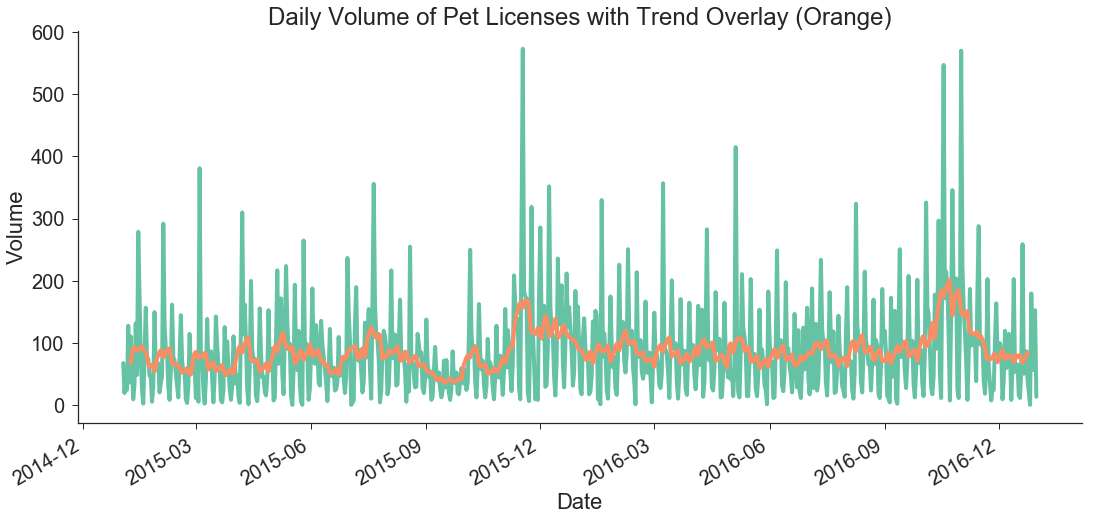

In [22]:
p = pd.concat([decomp2015.observed, 
               decomp2015.trend], axis=1).plot(figsize=(18,8), linewidth=4, legend=False)

sns.despine()
p.set_xlabel('Date')
p.set_ylabel('Volume')
p.set_title('Daily Volume of Pet Licenses with Trend Overlay (Orange)')

Looking more closely at the trend in combination with the original time-series, we do see a very slight rise in volume over time into 2016, indicating there could be a much longer trend at work. The spike in licensing in 2016 also appears to occur earlier than the peak in 2015, which was closer to the end of the year.

Before moving into the next section of the analysis which focuses on the issuing of pet licenses by particular zip codes in Seattle, let's see if there is any significant difference in the volume of licenses issued depending on the day of the week.

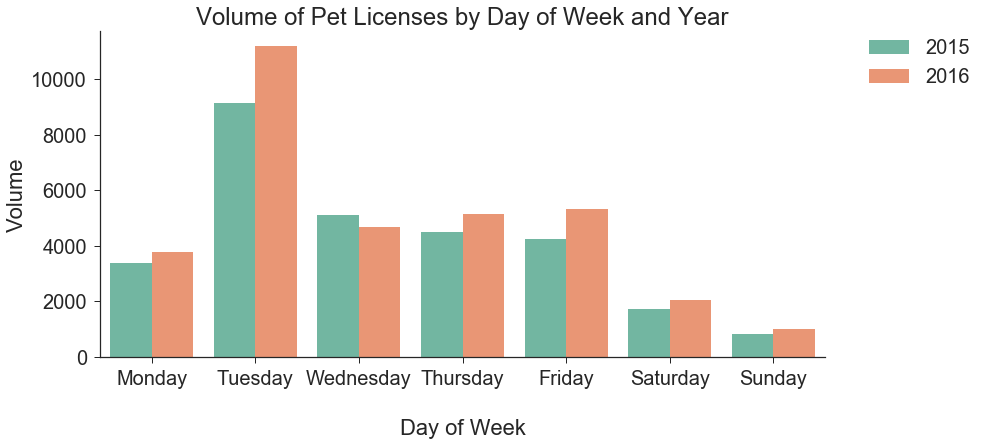

In [23]:
petlicense_date2015['Day of Week'] = petlicense_date2015.index.weekday_name
petlicense_date2015['Year'] = petlicense_date2015.index.year

dow = pd.pivot_table(petlicense_date2015, 
               index=['Day of Week', 'Year'], 
               values=['count'], aggfunc=np.sum).reset_index()

plt.figure(figsize=(13, 6))

p = sns.barplot(x='Day of Week', y='count', hue='Year', data=dow, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                                                                        'Friday', 'Saturday', 'Sunday'])
p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

p.set_ylabel('Volume')
p.set_title('Volume of Pet Licenses by Day of Week and Year')
p.xaxis.labelpad = 30
sns.despine()

Interestingly, Tuesday is when the majority of pet licenses are issued, followed by Thursday and Wednesday. This trend is also consistent in both years where data is available. 

## Do Higher Income Seattle Areas License Their Pets More Frequently Than Other Areas?

Earlier in the analysis, we noted only three zip codes have more than 5,000 licensed pets. Is there any likely cause or causes behind the stratification of licensed pets within the city of Seattle? One possible reason may be related to the demographics of the neighbors the zip codes encompass. For example, do more affluent areas of Seattle tend to have a higher amount of licensed pets? 

Using data provided by the IRS, we can analyze the number of tax returns received by different ranges of income and determine if there is any correlation between the number of pets licensed through the city. The data is available from the [IRS Statistics of Income](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2015-zip-code-data-soi) page. Clicking on an individual state on the map or from the list of states downloads an Excel file with a range of tax return statistics by income brackets. The most recent data available is from 2015, which is current enough for our purposes. In its raw form, the data is somewhat messy and hard to analyze. Therefore a cleaner copy in CSV format with only the data we need was created to facilitate the merging and analysis of the data. The CSV copy of the data can be downloaded from an [AWS S3 bucket](https://s3-us-west-2.amazonaws.com/animal-datasets/seattle-pet-licenses/seattle_pet_licenses.tar.gz). We load the data now using pandas and print the first few rows to check out the data.

In [24]:
zip_code_incomes = pd.read_csv('../../data/seattle pet licenses/wa_incomes_zip_code.csv')
zip_code_incomes['Zip Code'] = zip_code_incomes['Zip Code'].astype(str)

zip_code_incomes.head(5)

,Zip Code,Adjusted Gross Income,Number of returns,Number of single returns,Number of joint returns,Number of head of household returns,Number with paid preparer's signature,Number of exemptions,Number of dependents,Total prepared returns,Number of volunteer income tax assistance (VITA) prepared returns,Number of tax counseling for the elderly (TCE) prepared returns,Number of volunteer prepared returns with Earned Income Credit,Number of refund anticipation loan returns,Number of refund anticipation check returns,Number of elderly returns [3],Adjusted gross income (AGI) [4],Number of returns.1,Total Income Amount
0,0,"$1 under $25,000",1031890,752310,121550,145290,355420,1359740,380600,44360,17020,27340,5910,3490,129360,200930,13012107,1031890,13247026
1,0,"$25,000 under $50,000",802420,441230,207530,140030,306430,1522590,518490,25660,10970,14690,1130,1720,123500,163460,29258724,802420,29641465
2,0,"$50,000 under $75,000",499800,212790,227380,52020,213140,1062570,336010,9180,2810,6370,0,70,56410,136520,30815121,499800,31216336
3,0,"$75,000 under $100,000",342590,94490,222750,21260,152970,809050,243480,2280,420,1860,0,0,29330,102520,29730195,342590,30075682
4,0,"$100,000 under $200,000",525250,85250,419090,17920,247890,1369350,425340,440,210,230,0,0,26470,147960,71538405,525250,72442429


Let's quickly clean up the `Adjusted Gross Income` column by replacing 'under' with a hyphen. We also create a list of the column names that will be used later for changing the order of appearance of the income brackets in the visualization. The raw number of returns is transformed into a percentage of the total count of returns made within each respective zip code to see how the zip codes vary by the proportion of income brackets.

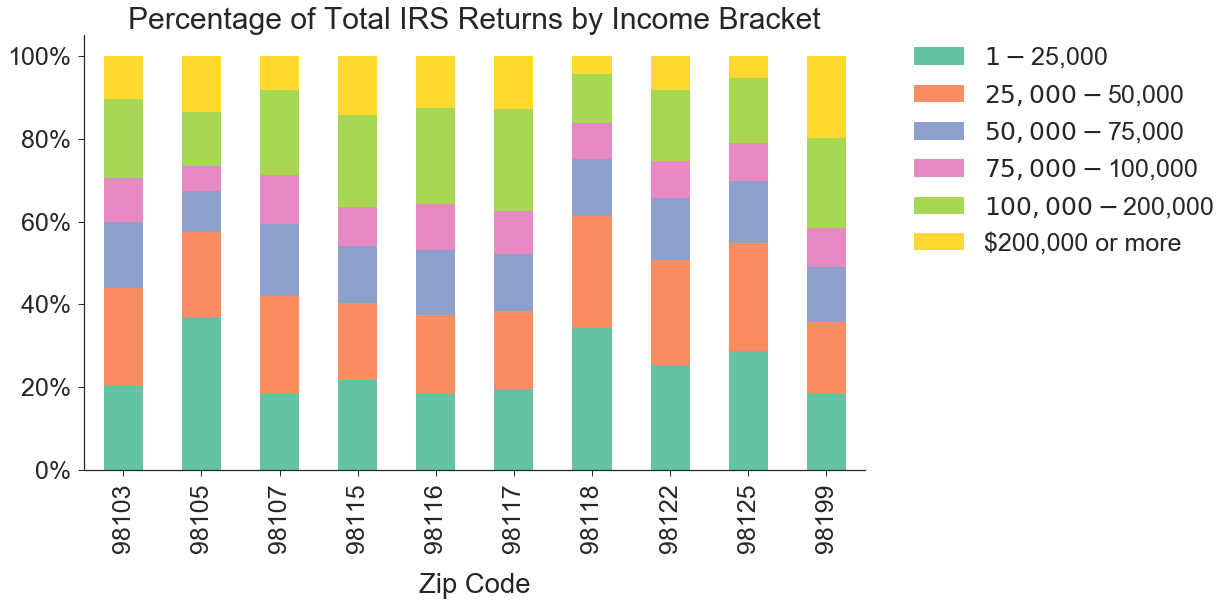

In [25]:
zip_code_incomes['Adjusted Gross Income'] = zip_code_incomes['Adjusted Gross Income'].str.replace(' under ', '-')
cols = zip_code_incomes['Adjusted Gross Income'].unique().tolist()

top10_zips = top15_zips[0:10]

zip_code_incomes_top10 = pd.pivot_table(zip_code_incomes, 
                                       index=['Zip Code', 'Adjusted Gross Income'], 
                                       values=['Number of returns'], aggfunc=np.sum).reset_index()

zip_code_incomes_top10 = zip_code_incomes_top10.loc[zip_code_incomes_top10['Zip Code'].isin(top10_zips.index)]

returns_percent = zip_code_incomes_top10.groupby(['Zip Code', 'Adjusted Gross Income']).agg({'Number of returns': 'sum'})

zip_code_incomes_top10_percentage = returns_percent.groupby(level=0).apply(lambda x: x / float(x.sum())).reset_index()

zip_code_incomes_top10_percentage = pd.pivot_table(zip_code_incomes_top10_percentage, index=['Zip Code'], 
                                                  columns=['Adjusted Gross Income'], values=['Number of returns'])

zip_code_incomes_top10_percentage = zip_code_incomes_top10_percentage['Number of returns'][cols]

sns.set(font_scale=2.5, palette=sns.color_palette("Set2", 10))
sns.set_style("ticks")

g = zip_code_incomes_top10_percentage.plot(kind='bar', stacked=True, 
                                           figsize=(14, 8), title='Percentage of Total IRS Returns by Income Bracket')

ticks = g.get_yticks()
g.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in ticks])
g.xaxis.labelpad = 20
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()

The majority of tax returns are from those making approximately \$75,000 or less. This majority is even higher in some zip codes such as 98118 and 98105, reaching nearly 60% of IRS filers. The 98199 zip code appears to be the most affluent based on data available according to the proportion of tax returns made by registrants with over \$100,000 in income.

Earlier, we saw the 98115, 98117 and 98103 zip codes have the most licensed pets. Based on the tax return data, these zip codes appear to be more affluent than others, but not by much. The 98199 zip code is in the middle regarding total licensed pets. With this knowledge, we can cast some doubt that there is a high correlation between the number of licensed pets and the affluence of the respective neighborhood.

Using pandas's handy [`corr()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) method and seaborn's [`heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) visualization function, we can construct a correlation matrix to see how the number of licensed pets correlates to the number of tax returns by various income brackets. To accomplish this, we must merge the two datasets using the zip code as the key. Pandas's [`merge()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) function is quite useful in combining data sets based on similar keys with a SQL-like interface. 

Text(0.5,1,'Pet License & Income Bracket Tax Return Correlation Matrix')

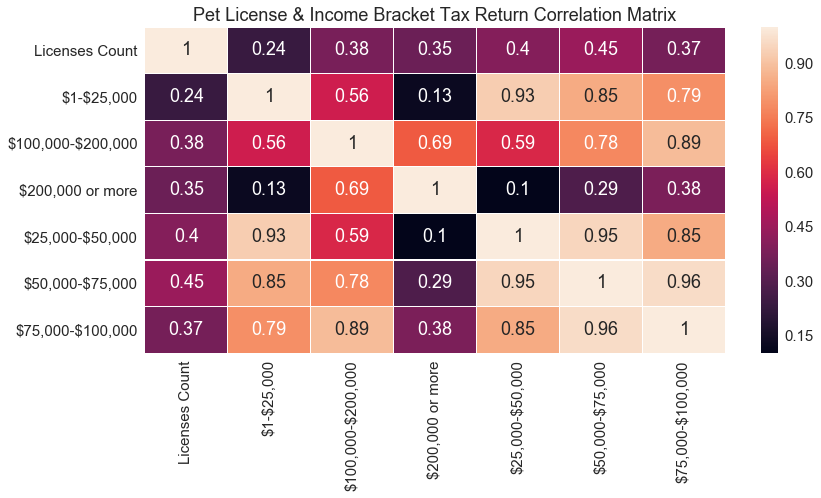

In [26]:
merged = pd.merge(petlicenses_species_zip, zip_code_incomes, 
                  how='left', left_on='zip_code', right_on='Zip Code').reset_index()

income_amounts = pd.pivot_table(zip_code_incomes, 
                                index=['Zip Code'], 
                                columns=['Adjusted Gross Income'], 
                                values=['Number of returns'], aggfunc=np.sum)

licenses_income_merged = pd.merge(petlicenses_zip, income_amounts, 
                                  how='left', left_index=True, right_index=True).reset_index() \
                                                                                .set_index('zip_code') \
                                                                                .dropna() \
                                                                                .sort_values('count', ascending=False)

sns.set(font_scale=1.5)

license_corr = licenses_income_merged.corr()
labels = ['Licenses Count', '\$1-$25,000', '\$100,000-$200,000', '\$200,000 or more', 
          '\$25,000-$50,000', '\$50,000-$75,000', '\$75,000-$100,000']

plt.figure(figsize=(13, 6))

p = sns.heatmap(license_corr, annot=True, linewidths=0.25,
            xticklabels=labels,
            yticklabels=labels)

p.set_title('Pet License & Income Bracket Tax Return Correlation Matrix')

The correlations to the number of returns by income bracket and total pet licenses can be found in the first column and first row of the correlation matrix. We see the correlations are not strong in the absolute sense (close to 1) but could be considered high or significant as the data is social and economic in nature. Interestingly, the income brackets with the highest correlations to pets licensed are in the \$25,000 to \$75,000 range, while the larger income brackets, \$100,000 to more than \$200,000, are slightly lower.  

Based on these results, it seems there could be something of a relationship between the number of licensed pets and the wealth of the particular area, but if there is it is most likely quite weak. Another method of finding any possible relationships in the data is to perform [linear regression](https://en.wikipedia.org/wiki/Linear_regression), a standard model that fits a linear equation to a dependent variable and one or more independent variables. Although linear regression in its purer forms is comparatively straightforward to more exotic approaches, the technique is still quite powerful and is very much in use today due to its relative ease of use and interpretability, as well as the amount of information that can be gleaned from inspecting the model.

Several popular Python libraries can perform linear regression, of which include [scikit-learn's LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), [numpy's lstsq](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.lstsq.html#numpy.linalg.lstsq), and [Statsmodels' OLS](http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html), all of which are different and offer various advantages. For our purposes, we are more interested in the model's diagnostics and tests to see if we can find any additional useful information for identifying any relationship between the frequency of pet licensing and the affluence of individual neighborhoods. The Statsmodels implementation provides a very lovely R-like summary of the linear regression model fit, which fits nicely for our need.

To fit the linear model using the [Statsmodels](http://www.statsmodels.org/dev/index.html) library, we first create the x (independent) and y (dependent) variables. According to the [`OLS()`](http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html) documentation, a constant that represents the intercept must be added using [`add_constant`](http://www.statsmodels.org/dev/generated/statsmodels.tools.tools.add_constant.html) before fitting the model.

In [27]:
x = licenses_income_merged.loc[:, licenses_income_merged.columns[1]:]
y = licenses_income_merged.loc[:,'count']

x_constant = sm.add_constant(x)

model = sm.OLS(y, x_constant)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     10.94
Date:                Fri, 09 Mar 2018   Prob (F-statistic):           1.17e-08
Time:                        06:12:44   Log-Likelihood:                -667.86
No. Observations:                  80   AIC:                             1350.
Df Residuals:                      73   BIC:                             1366.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

The [Statsmodels `summary()`](http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.summary.html) method prints a nice table of the linear regression fit results. We see the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), better known as $R^2$ is slightly under $0.50$ and a p-value well below $0.05$. Looking at the individual model coefficients, only the \$75k-\$100k range coefficient has a p-value below 0.05, though the \$50k-\$75k range just barely misses the threshold at $0.058$. The \$50k-\$75k was also the most correlated with the number of pet licenses. The higher income bracket coefficients have much larger p-values. Thus we would consider removing those terms from the model if we wanted to achieve a more precise fit. 

Based on the results of the model and the correlations reported from the correlation matrix, we can say there is not a relationship between the number of licensed pets within a zip code and the general affluence of that zip code as represented by the volume of tax returns for various income brackets. Given that the cost of a pet license is relatively inexpensive, only about \$20 for each pet, these results are not unreasonable and align with several of the possible conclusions that were considered earlier. Though the correlations could be thought of as somewhat strong given the social and economic nature of the data we are working with, we've seen that this correlation likely does not imply causation, as the old saying goes.

## Conclusion

We explored several facets of the [Seattle Pet Licenses dataset](https://data.seattle.gov/Community/Seattle-Pet-Licenses/jguv-t9rb) in this analysis and found several interesting pieces of information that could be useful in a variety of different ways. One possible use of such information is planning a marketing or outreach campaign to target cat owners who haven't considered licensing their cat in zip codes with a higher disparity between the number of cats and dogs. What follows is a summary some of the new information we learned from performing this analysis:

* The most popular dog and cat name in Seattle according to data available is Lucy. 30 of the top 50, dog and cat names are shared.
* There are only three zip codes with more than 5,000 licensed pets. We saw there isn't much of a relationship between the number of licensed pets and the distribution of wealth in a particular zip code. Therefore there are other factors that contribute to the number of licensed pets.
* The number of pets licensed appears to trend upwards near the end of the year, specifically the fourth quarter. This trend has occurred for the past two years so it will be interesting to see if it continues in 2017 (should data become available).
* Dogs are licensed almost twice as much as cats, although there are an [estimated five million more pet cats](https://www.animalsheltering.org/page/pets-by-the-numbers) in the United States. It is difficult to say conclusively why this would be without more data; however, one could reasonably assume one factor is a misconception that a dog is more likely to go missing than an indoor cat.
* Somewhat surprisingly, the most active day of the week for pet licensing is Tuesday. Given that the Seattle Animal Shelter offers a free rabies vaccine and other cost-effective services for owners who receive or renew their pet license on the third Saturday of each month, one would reasonably assume Saturday would be a higher volume day.
* The correlation between the number of licensed pets and the distribution of wealth in a particular area according to the volume of tax returns for various income brackets could be considered strong given the social context of the data; however, this does not imply any causation.